In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.coordinates as coord
import astropy.units as u
import gala.coordinates as gc
import h5py

from scipy import spatial

%matplotlib inline
np.random.seed(7649742)

In [2]:
plt.style.use('notebook')

In [3]:
f = h5py.File('../data/point_cat_ukidss.h5','r')

In [5]:
ce = coord.SkyCoord(ra=f['SKY_COORDS'][:,0]*u.deg, dec=f['SKY_COORDS'][:,1]*u.deg,
                         distance=f['DISTANCE'][:,1]*u.kpc, pm_ra_cosdec=f['PROPER_MOTION'][:,0]*u.mas/u.yr,
                         pm_dec=f['PROPER_MOTION'][:,1]*u.mas/u.yr,
                         frame='icrs')

/usr/lib64/python3.6/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [78]:
giants = (f['LOG10_SURF_GRAV'][:,1]<3.5) & ~f['FLAG_FIT'][:] & ~f['FLAG_GRID'][:]
ind_contiguous = (ce.dec<17*u.deg) & (ce.ra>120*u.deg) & (ce.ra<250*u.deg)
ind_pal5box = (ce.dec<17*u.deg) & (ce.ra>200*u.deg) & (ce.ra<250*u.deg)
ind_pm = ((ce.pm_ra_cosdec<6*u.mas/u.yr) & (ce.pm_ra_cosdec>-12*u.mas/u.yr) & (ce.pm_dec<6*u.mas/u.yr)
         & (ce.pm_dec>-12*u.mas/u.yr))

In [79]:
# create a 4D data array
data = np.vstack([ce.ra.deg, ce.dec.deg,
                  ce.pm_ra_cosdec.to(u.mas/u.yr).value,
                  ce.pm_dec.to(u.mas/u.yr).value])[:,ind_pal5box & giants & ind_pm].T
np.shape(data)

(24893, 4)

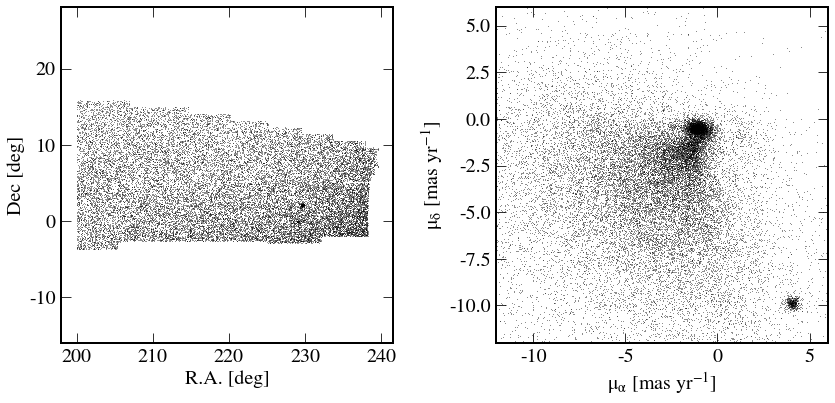

In [80]:
# check the data
fig, ax = plt.subplots(1,2,figsize=(12,6))
plt.sca(ax[0])
plt.plot(data[:,0], data[:,1], 'k.', ms=1.5, mec='none')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')

plt.sca(ax[1])
plt.plot(data[:,2], data[:,3], 'k.', ms=1.5, mec='none')
plt.xlim(-12,6)
plt.ylim(-12,6)
plt.xlabel('$\mu_\\alpha$ [mas yr$^{-1}$]')
plt.ylabel('$\mu_\delta$ [mas yr$^{-1}$]')

plt.tight_layout()

In [81]:
# build kd tree on positions
tree_pos = spatial.KDTree(data[:, :2])

In [82]:
# get densities
inrad = 0.015 # MAGIC
foo = tree_pos.query_pairs(inrad)
N1 = np.bincount(np.array([q for q in foo]).flatten())
fac = 4. # MAGIC
foo = tree_pos.query_pairs(fac * inrad)
N2 = np.bincount(np.array([q for q in foo]).flatten())

In [83]:
N1.shape, N2.shape, data.shape

((24799,), (24884,), (24893, 4))

In [31]:
tiny = 0.5 / 8.
pos_overdensities = (N1 - N2 / fac ** 2) / np.clip((N2 - N1) / (fac **2 - 1.), tiny, np.inf)
print(pos_overdensities.shape, np.min(pos_overdensities), np.median(pos_overdensities), np.max(pos_overdensities))

ValueError: operands could not be broadcast together with shapes (27990,) (28084,) 